timeseries shape: (89, 422, 315)


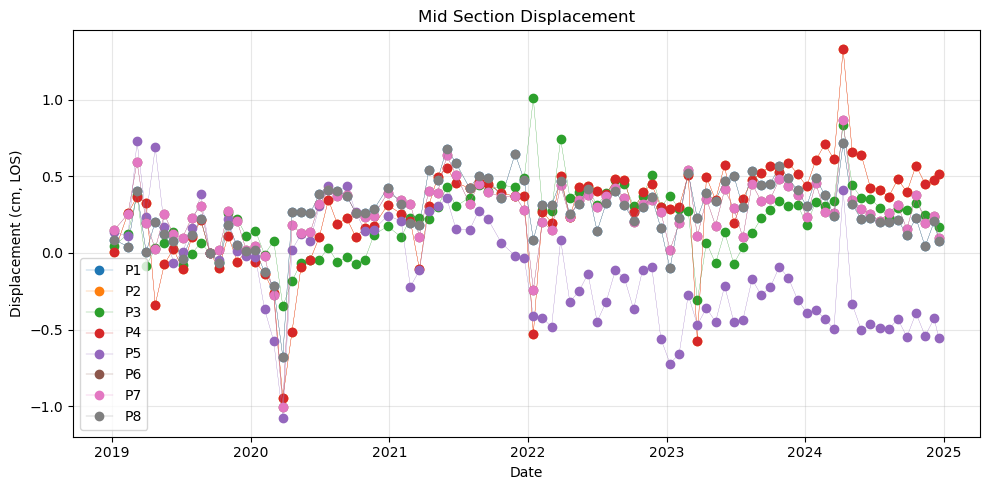

In [14]:
import os
os.chdir("/insar-data/Tocantins/mintpy")

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mintpy.utils import readfile
import h5py
import csv

# --- helpers ---
def parse_points(s):
    pts = []
    for item in s.split(";"):
        lat_str, lon_str = item.strip().split(",")
        pts.append((float(lat_str), float(lon_str)))
    return pts

def latlon_to_rc(meta, lat, lon):
    x0 = float(meta["X_FIRST"])
    y0 = float(meta["Y_FIRST"])
    dx = float(meta["X_STEP"])
    dy = float(meta["Y_STEP"])    # often negative
    width  = int(meta["WIDTH"])
    length = int(meta["LENGTH"])
    col = int(round((lon - x0) / dx))
    row = int(round((lat - y0) / dy))
    if not (0 <= row < length and 0 <= col < width):
        raise IndexError(f"Point ({lat:.6f},{lon:.6f}) -> (row={row}, col={col}) outside data [{length}x{width}]")
    return row, col

def _to_str_array(x):
    """Normalize various 'date list' representations to an array of 'YYYYMMDD' strings."""
    if isinstance(x, np.ndarray):
        if x.dtype.kind in ("S", "U", "O"):
            arr = [xi.decode() if isinstance(xi, (bytes, bytearray)) else str(xi) for xi in x.tolist()]
        else:  # e.g., int array like [20171005, ...]
            arr = [f"{int(xi):08d}" for xi in x.tolist()]
    elif isinstance(x, (bytes, bytearray, str)):
        s = x.decode() if isinstance(x, (bytes, bytearray)) else x
        # split on whitespace/commas
        arr = [t for t in s.replace(",", " ").split() if t]
    else:
        arr = [str(x)]
    return np.array(arr)

def get_dates(h5_file):
    """Robust date reader: try '/date' dataset; fall back to DATE_LIST or similar attrs (root or '/timeseries')."""
    # 1) try the standard dataset via MintPy reader
    try:
        dates_raw, _ = readfile.read(h5_file, datasetName="date")
        return np.array([d.decode() if isinstance(d, (bytes, bytearray)) else str(d) for d in dates_raw])
    except Exception:
        pass

    # 2) fall back to HDF5 inspection
    with h5py.File(h5_file, "r") as f:
        # dataset '/date'
        if "date" in f:
            return _to_str_array(f["date"][:])

        # common attributes that may hold the date list
        root_keys = ["DATE_LIST", "DATE", "DATES"]
        ts_keys   = ["DATE_LIST", "DATE", "DATES", "date"]
        for k in root_keys:
            if k in f.attrs:
                return _to_str_array(f.attrs[k])
        if "timeseries" in f:
            for k in ts_keys:
                if k in f["timeseries"].attrs:
                    return _to_str_array(f["timeseries"].attrs[k])

        # as a last resort, try metadata from MintPy reader (some builds store 'DATE_LIST' in meta)
        try:
            _, meta = readfile.read(h5_file)
            for k in ["DATE_LIST", "DATE", "DATES"]:
                if k in meta:
                    return _to_str_array(meta[k])
        except Exception:
            pass

    raise RuntimeError("Could not find dates in the file (no '/date' dataset or date attributes like 'DATE_LIST').")


# --- your inputs ---
points_str = "-6.560158255949814,-47.46016031382688;-6.560084486019452,-47.45984719931455;-6.55998743317107,-47.45952563669299;-6.559995140893733,-47.45973808206099;-6.560049652775545,-47.45997379133239;-6.560122951860897,-47.46027331358496;-6.560192457457181,-47.46045589924103;-6.560158255949814,-47.46016031382688"
labels = "P1;P2;P3;P4;P5;P6;P7;P8"

h5_file = "/insar-data/Tocantins/mintpy/geo/geo_timeseries_ERA5_demErr.h5"
# h5_file = "/insar-data/Tocantins/mintpy/timeseries_ERA5_demErr.h5"  # radar coords need lookup table (not used here)

points = parse_points(points_str)
labels = labels.split(";") if labels else [f"{lat:.5f},{lon:.5f}" for lat, lon in points]

# --- read data (like tsview.py) ---
ts, meta = readfile.read(h5_file)  # 3-D (n_date, length, width), meters
print("timeseries shape:", ts.shape)

dates = get_dates(h5_file)
dates_dt = np.array([datetime.strptime(d, "%Y%m%d") for d in dates])

# --- sample points (nearest pixel) ---
series_cm = []
for (lat, lon) in points:
    r, c = latlon_to_rc(meta, lat, lon)
    disp_m = ts[:, r, c]
    series_cm.append(disp_m * 100.0)

# --- save outputs (mimic --nodisplay --save) ---
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_{len(points)}pts.png"
csv_name = f"{outbase}_ts_{len(points)}pts.csv"

plt.figure(figsize=(10, 5))
for y, label in zip(series_cm, labels):
    plt.plot(dates_dt, y, marker="o", linewidth=0.2, label=label)
plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Mid Section Displacement")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(fig_name, dpi=200)
#plt.close()

with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + labels)
    for i, d in enumerate(dates):
        w.writerow([d] + [float(series_cm[j][i]) for j in range(len(points))])


In [ ]:
sections = {
    "Mid": {
        "points_str": "-6.560158255949814,-47.46016031382688;-6.560084486019452,-47.45984719931455;-6.55998743317107,-47.45952563669299;-6.559995140893733,-47.45973808206099;-6.560049652775545,-47.45997379133239;-6.560122951860897,-47.46027331358496;-6.560192457457181,-47.46045589924103;-6.560158255949814,-47.46016031382688",
        "labels": "P1;P2;P3;P4;P5;P6;P7;P8"
    },
    "East": {
        "points_str": "-6.559925965452411,-47.4591190204194;-6.55987243853964,-47.45885963844137;-6.559780269673255,-47.45857778034037;-6.559780697683596,-47.45875172976733;-6.559830395017721,-47.45899198540491;-6.559878277172793,-47.45923129609326;-6.559954570599227,-47.45938935719469;-6.559925965452411,-47.4591190204194",
        "labels": "P1;P2;P3;P4;P5;P6;P7;P8"
    },
    
    # Add “Upstream” and “Downstream” (or Span1, Span3, etc.) when you have them:
    # "Upstream": {"points_str": "...", "labels": "..."},
    # "Downstream": {"points_str": "...", "labels": "..."},
}

timeseries shape: (89, 422, 315)


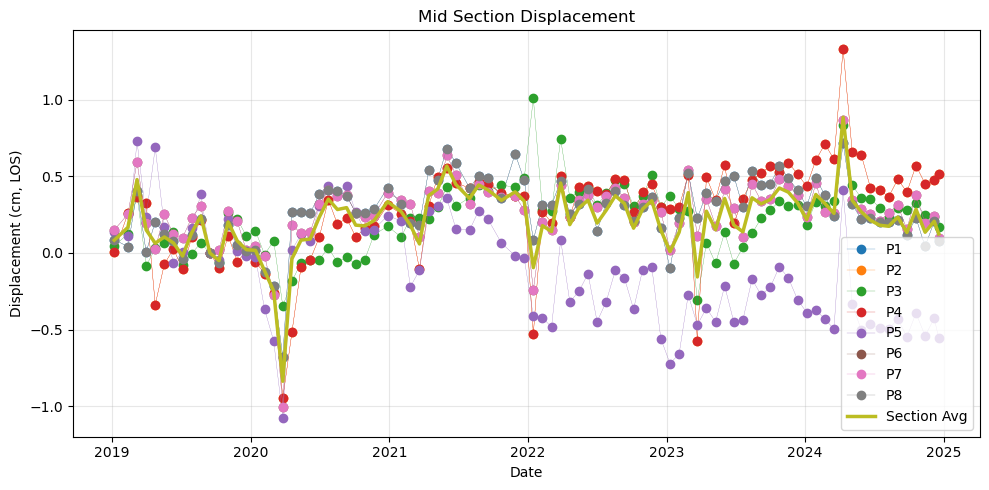

In [15]:
import os
os.chdir("/insar-data/Tocantins/mintpy")

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mintpy.utils import readfile
import h5py
import csv

# --- helpers ---
def parse_points(s):
    pts = []
    for item in s.split(";"):
        lat_str, lon_str = item.strip().split(",")
        pts.append((float(lat_str), float(lon_str)))
    return pts

def latlon_to_rc(meta, lat, lon):
    x0 = float(meta["X_FIRST"])
    y0 = float(meta["Y_FIRST"])
    dx = float(meta["X_STEP"])
    dy = float(meta["Y_STEP"])    # often negative
    width  = int(meta["WIDTH"])
    length = int(meta["LENGTH"])
    col = int(round((lon - x0) / dx))
    row = int(round((lat - y0) / dy))
    if not (0 <= row < length and 0 <= col < width):
        raise IndexError(f"Point ({lat:.6f},{lon:.6f}) -> (row={row}, col={col}) outside data [{length}x{width}]")
    return row, col

def _to_str_array(x):
    """Normalize various 'date list' representations to an array of 'YYYYMMDD' strings."""
    if isinstance(x, np.ndarray):
        if x.dtype.kind in ("S", "U", "O"):
            arr = [xi.decode() if isinstance(xi, (bytes, bytearray)) else str(xi) for xi in x.tolist()]
        else:  # e.g., int array like [20171005, ...]
            arr = [f"{int(xi):08d}" for xi in x.tolist()]
    elif isinstance(x, (bytes, bytearray, str)):
        s = x.decode() if isinstance(x, (bytes, bytearray)) else x
        # split on whitespace/commas
        arr = [t for t in s.replace(",", " ").split() if t]
    else:
        arr = [str(x)]
    return np.array(arr)

def get_dates(h5_file):
    """Robust date reader: try '/date' dataset; fall back to DATE_LIST or similar attrs (root or '/timeseries')."""
    # 1) try the standard dataset via MintPy reader
    try:
        dates_raw, _ = readfile.read(h5_file, datasetName="date")
        return np.array([d.decode() if isinstance(d, (bytes, bytearray)) else str(d) for d in dates_raw])
    except Exception:
        pass

    # 2) fall back to HDF5 inspection
    with h5py.File(h5_file, "r") as f:
        # dataset '/date'
        if "date" in f:
            return _to_str_array(f["date"][:])

        # common attributes that may hold the date list
        root_keys = ["DATE_LIST", "DATE", "DATES"]
        ts_keys   = ["DATE_LIST", "DATE", "DATES", "date"]
        for k in root_keys:
            if k in f.attrs:
                return _to_str_array(f.attrs[k])
        if "timeseries" in f:
            for k in ts_keys:
                if k in f["timeseries"].attrs:
                    return _to_str_array(f["timeseries"].attrs[k])

        # as a last resort, try metadata from MintPy reader (some builds store 'DATE_LIST' in meta)
        try:
            _, meta = readfile.read(h5_file)
            for k in ["DATE_LIST", "DATE", "DATES"]:
                if k in meta:
                    return _to_str_array(meta[k])
        except Exception:
            pass

    raise RuntimeError("Could not find dates in the file (no '/date' dataset or date attributes like 'DATE_LIST').")


# --- your inputs ---
points_str = "-6.560158255949814,-47.46016031382688;-6.560084486019452,-47.45984719931455;-6.55998743317107,-47.45952563669299;-6.559995140893733,-47.45973808206099;-6.560049652775545,-47.45997379133239;-6.560122951860897,-47.46027331358496;-6.560192457457181,-47.46045589924103;-6.560158255949814,-47.46016031382688"
labels = "P1;P2;P3;P4;P5;P6;P7;P8"

h5_file = "/insar-data/Tocantins/mintpy/geo/geo_timeseries_ERA5_demErr.h5"
# h5_file = "/insar-data/Tocantins/mintpy/timeseries_ERA5_demErr.h5"  # radar coords need lookup table (not used here)

points = parse_points(points_str)
labels = labels.split(";") if labels else [f"{lat:.5f},{lon:.5f}" for lat, lon in points]

# --- read data (like tsview.py) ---
ts, meta = readfile.read(h5_file)  # 3-D (n_date, length, width), meters
print("timeseries shape:", ts.shape)

dates = get_dates(h5_file)
dates_dt = np.array([datetime.strptime(d, "%Y%m%d") for d in dates])

# --- sample points (nearest pixel) ---
series_cm = []
for (lat, lon) in points:
    r, c = latlon_to_rc(meta, lat, lon)
    disp_m = ts[:, r, c]
    series_cm.append(disp_m * 100.0)

# NEW: stack and compute section average (robust to NaNs)
series_arr = np.vstack(series_cm)               # shape: (n_pts, n_dates)
avg_series_cm = np.nanmean(series_arr, axis=0)  # shape: (n_dates,)




plt.figure(figsize=(10, 5))
for y, label in zip(series_cm, labels):
    plt.plot(dates_dt, y, marker="o", linewidth=0.2, label=label)

# NEW: overlay section average as a bold line
plt.plot(dates_dt, avg_series_cm, linewidth=2.5, label="Section Avg")

plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Mid Section Displacement")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(fig_name, dpi=200)
#plt.close()


timeseries shape: (89, 422, 315)


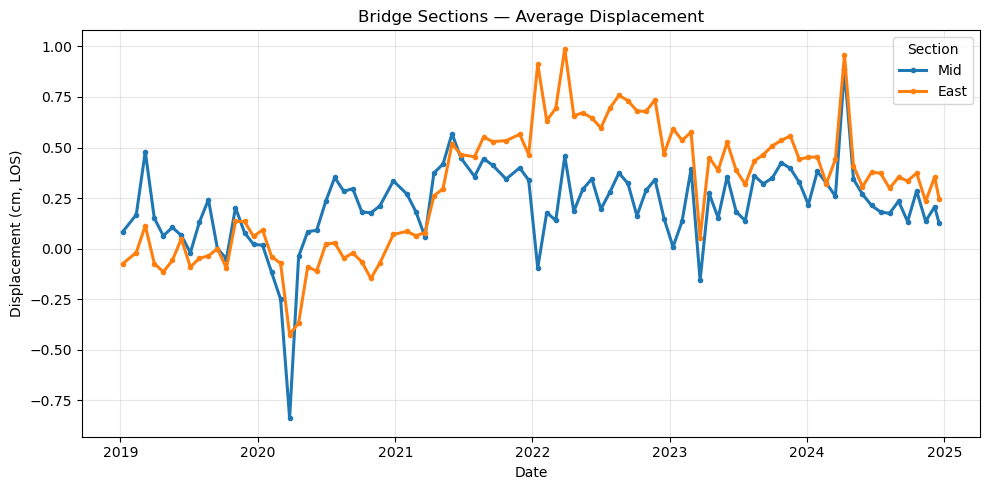

In [16]:
# --- your inputs: sections instead of a single point list ---
sections = {
    "Mid": {
        "points_str": "-6.560158255949814,-47.46016031382688;-6.560084486019452,-47.45984719931455;-6.55998743317107,-47.45952563669299;-6.559995140893733,-47.45973808206099;-6.560049652775545,-47.45997379133239;-6.560122951860897,-47.46027331358496;-6.560192457457181,-47.46045589924103;-6.560158255949814,-47.46016031382688",
        "labels": "P1;P2;P3;P4;P5;P6;P7;P8"
    },
    "East": {
        "points_str": "-6.559925965452411,-47.4591190204194;-6.55987243853964,-47.45885963844137;-6.559780269673255,-47.45857778034037;-6.559780697683596,-47.45875172976733;-6.559830395017721,-47.45899198540491;-6.559878277172793,-47.45923129609326;-6.559954570599227,-47.45938935719469;-6.559925965452411,-47.4591190204194",
        "labels": "P1;P2;P3;P4;P5;P6;P7;P8"
    },
    # "Upstream": {"points_str": "...", "labels": "..."},
    # "Downstream": {"points_str": "...", "labels": "..."},
}

h5_file = "/insar-data/Tocantins/mintpy/geo/geo_timeseries_ERA5_demErr.h5"

# --- read data (like tsview.py) ---
ts, meta = readfile.read(h5_file)  # 3-D (n_date, length, width), meters
print("timeseries shape:", ts.shape)

dates = get_dates(h5_file)
dates_dt = np.array([datetime.strptime(d, "%Y%m%d") for d in dates])

# --- compute per-section averages (cm) ---
section_avg = {}  # name -> (n_dates,) array in cm
for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])
    # optional: labels = cfg.get("labels", None)  # not used for plotting-only-avg

    # collect each point's series
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # meters -> cm

    # average across points, per date (robust to NaNs)
    arr = np.vstack(series_cm)                    # (n_pts, n_dates)
    section_avg[sec_name] = np.nanmean(arr, axis=0)  # (n_dates,)

# --- save outputs and plot ONLY the per-section averages ---
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_sectionAvgs.png"
csv_name = f"{outbase}_ts_sectionAvgs.csv"

plt.figure(figsize=(10, 5))
for sec_name, avg_series_cm in section_avg.items():
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=sec_name)

plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement")
plt.grid(True, alpha=0.3)
plt.legend(title="Section")
plt.tight_layout()
plt.show()
# plt.savefig(fig_name, dpi=200); plt.close()

# CSV with one column per section average
with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + list(section_avg.keys()))
    for i, d in enumerate(dates):
        w.writerow([d] + [float(section_avg[name][i]) for name in section_avg.keys()])

In [18]:
# ---------- NEW: anomaly detection config ----------
ANOM_CM_THRESH = 0.7      # cm residual threshold
ANOM_Z_THRESH = 3.5       # robust z-score threshold
ANOM_MIN_HITS = 2         # minimum total anomaly hits for a point
ANOM_MIN_CONSEC = 2       # minimum consecutive anomaly hits
# ---------------------------------------------------


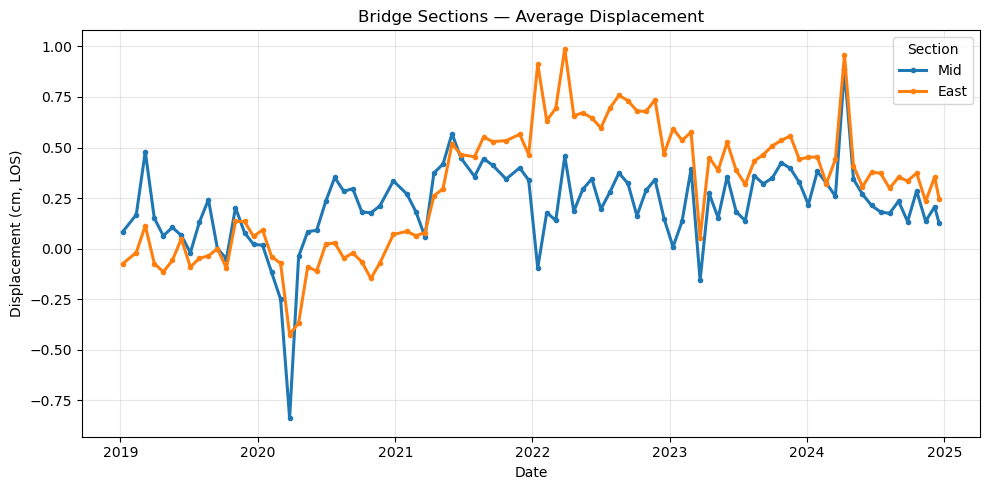

Anomaly summary written to: geo_timeseries_ERA5_demErr_anomalies.csv


In [19]:
# --- compute per-section averages (cm) + anomaly detection ---
def _max_run_length(bool_arr):
    """Max consecutive True run length in a 1D boolean array."""
    m = 0
    cur = 0
    for b in bool_arr:
        cur = cur + 1 if b else 0
        if cur > m:
            m = cur
    return m

section_avg = {}  # name -> (n_dates,) array in cm
anom_rows = []    # rows for the anomaly CSV

for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])
    labels_str = cfg.get("labels", "")
    if labels_str:
        point_labels = labels_str.split(";")
    else:
        point_labels = [f"{lat:.5f},{lon:.5f}" for (lat, lon) in pts]

    # collect each point's series
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # meters -> cm

    # section average across points, per date (robust to NaNs)
    arr = np.vstack(series_cm)                     # (n_pts, n_dates)
    avg_cm = np.nanmean(arr, axis=0)               # (n_dates,)
    section_avg[sec_name] = avg_cm

    # --- NEW: per-point residuals & robust z-scores ---
    resid = arr - avg_cm                           # broadcast over dates
    med = np.nanmedian(resid, axis=1, keepdims=True)
    mad = np.nanmedian(np.abs(resid - med), axis=1, keepdims=True)
    robust_std = 1.4826 * mad
    z = (resid - med) / (robust_std + 1e-9)

    # anomaly mask per (point, date)
    anom_mask = (np.abs(resid) > ANOM_CM_THRESH) & (np.abs(z) > ANOM_Z_THRESH)

    # --- NEW: summarize anomalies per point ---
    for i, (label, (lat, lon)) in enumerate(zip(point_labels, pts)):
        hits_idx = np.where(anom_mask[i])[0]
        n_hits = int(hits_idx.size)
        max_run = _max_run_length(anom_mask[i])
        flagged = (n_hits >= ANOM_MIN_HITS) and (max_run >= ANOM_MIN_CONSEC)
        first_date = dates[hits_idx[0]] if n_hits > 0 else ""
        last_date  = dates[hits_idx[-1]] if n_hits > 0 else ""

        anom_rows.append([
            sec_name, label, float(lat), float(lon),
            n_hits, max_run, first_date, last_date,
            float(np.nanmax(np.abs(resid[i]))) if n_hits > 0 else 0.0,
            float(np.nanmax(np.abs(z[i]))) if n_hits > 0 else 0.0,
            int(flagged)
        ])

# --- keep the plot: ONLY per-section averages ---
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_sectionAvgs.png"
csv_name = f"{outbase}_ts_sectionAvgs.csv"
anom_csv = f"{outbase}_anomalies.csv"

plt.figure(figsize=(10, 5))
for sec_name, avg_series_cm in section_avg.items():
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=sec_name)
plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement")
plt.grid(True, alpha=0.3)
plt.legend(title="Section")
plt.tight_layout()
plt.show()
# plt.savefig(fig_name, dpi=200); plt.close()

# CSV with one column per section average
with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + list(section_avg.keys()))
    for i, d in enumerate(dates):
        w.writerow([d] + [float(section_avg[name][i]) for name in section_avg.keys()])

# --- NEW: write anomaly summary CSV (one row per point) ---
with open(anom_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "section", "point_label", "lat", "lon",
        "n_anom_hits", "max_consecutive_hits",
        "first_anom_date", "last_anom_date",
        "max_abs_residual_cm", "max_abs_robust_z",
        "flagged"  # 1 if passes thresholds & persistence
    ])
    w.writerows(anom_rows)

print(f"Anomaly summary written to: {anom_csv}")


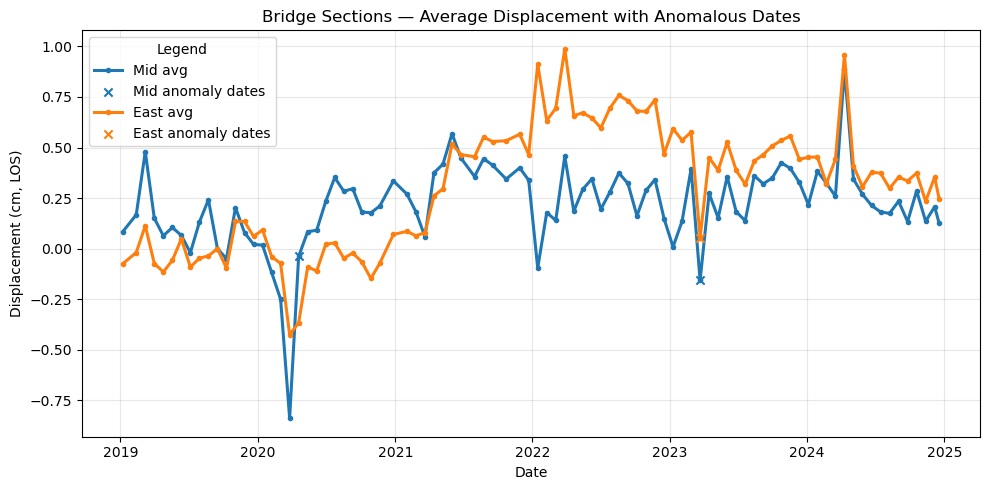

Per-date anomaly counts written to: geo_timeseries_ERA5_demErr_anom_dates.csv

[Mid] Anomalous dates (>= 2 points):
  date        | #anom_pts
  ------------+----------
  20200419 | 2
  20230323 | 2

[East] Anomalous dates (>= 2 points):
  date        | #anom_pts
  ------------+----------
  20230323 | 2


In [ ]:
# ---------- NEW: anomaly detection config ----------
ANOM_CM_THRESH = 0.5      # cm residual threshold
ANOM_Z_THRESH = 3.5       # robust z-score threshold
ANOM_MIN_HITS = 2         # minimum total anomaly hits for a point
ANOM_MIN_CONSEC = 2       # minimum consecutive anomaly hits
ANOM_DATE_MIN_POINTS = 2   # min # of points anomalous on the same date to mark the date
# ---------------------------------------------------
# --- compute per-section averages (cm) + anomaly detection + per-date aggregation ---
def _max_run_length(bool_arr):
    """Max consecutive True run length in a 1D boolean array."""
    m = 0
    cur = 0
    for b in bool_arr:
        cur = cur + 1 if b else 0
        if cur > m:
            m = cur
    return m

section_avg = {}             # name -> (n_dates,) array in cm
section_date_counts = {}     # name -> (n_dates,) int (# anomalous points per date)
section_flagged_idx = {}     # name -> np.array of indices for flagged dates
anom_rows = []               # rows for per-point anomaly CSV

for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])
    labels_str = cfg.get("labels", "")
    if labels_str:
        point_labels = labels_str.split(";")
    else:
        point_labels = [f"{lat:.5f},{lon:.5f}" for (lat, lon) in pts]

    # collect each point's series
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # m -> cm

    # section average across points, per date (robust to NaNs)
    arr = np.vstack(series_cm)                  # (n_pts, n_dates)
    avg_cm = np.nanmean(arr, axis=0)            # (n_dates,)
    section_avg[sec_name] = avg_cm

    # --- per-point residuals & robust z-scores ---
    resid = arr - avg_cm                        # broadcast over dates
    med = np.nanmedian(resid, axis=1, keepdims=True)
    mad = np.nanmedian(np.abs(resid - med), axis=1, keepdims=True)
    robust_std = 1.4826 * mad
    z = (resid - med) / (robust_std + 1e-9)

    # anomaly mask per (point, date)
    anom_mask = (np.abs(resid) > ANOM_CM_THRESH) & (np.abs(z) > ANOM_Z_THRESH)

    # summarize anomalies per point (for the per-point CSV)
    for i, (label, (lat, lon)) in enumerate(zip(point_labels, pts)):
        hits_idx = np.where(anom_mask[i])[0]
        n_hits = int(hits_idx.size)
        max_run = _max_run_length(anom_mask[i])
        flagged = (n_hits >= ANOM_MIN_HITS) and (max_run >= ANOM_MIN_CONSEC)
        first_date = dates[hits_idx[0]] if n_hits > 0 else ""
        last_date  = dates[hits_idx[-1]] if n_hits > 0 else ""

        anom_rows.append([
            sec_name, label, float(lat), float(lon),
            n_hits, max_run, first_date, last_date,
            float(np.nanmax(np.abs(resid[i]))) if n_hits > 0 else 0.0,
            float(np.nanmax(np.abs(z[i]))) if n_hits > 0 else 0.0,
            int(flagged)
        ])

    # --- NEW: aggregate anomalies per date within the section ---
    counts = np.sum(anom_mask, axis=0).astype(int)     # (# anomalous points per date)
    section_date_counts[sec_name] = counts
    section_flagged_idx[sec_name] = np.where(counts >= ANOM_DATE_MIN_POINTS)[0]

# --- plot: section averages + overlay of flagged dates ---
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_sectionAvgs.png"
csv_name = f"{outbase}_ts_sectionAvgs.csv"
anom_csv = f"{outbase}_anomalies.csv"
anom_date_csv = f"{outbase}_anom_dates.csv"

plt.figure(figsize=(10, 5))
for sec_name, avg_series_cm in section_avg.items():
    # average curve
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=f"{sec_name} avg")
    # NEW: overlay flagged dates (where >= ANOM_DATE_MIN_POINTS anomalous points)
    idx = section_flagged_idx[sec_name]
    if idx.size > 0:
        plt.scatter(dates_dt[idx], avg_series_cm[idx], s=35, marker="x", zorder=4, label=f"{sec_name} anomaly dates")

plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement with Anomalous Dates")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()
# plt.savefig(fig_name, dpi=200); plt.close()

# CSV with one column per section average
with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + list(section_avg.keys()))
    for i, d in enumerate(dates):
        w.writerow([d] + [float(section_avg[name][i]) for name in section_avg.keys()])

# per-point anomaly summary CSV (already from step 2)
with open(anom_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "section", "point_label", "lat", "lon",
        "n_anom_hits", "max_consecutive_hits",
        "first_anom_date", "last_anom_date",
        "max_abs_residual_cm", "max_abs_robust_z",
        "flagged"
    ])
    w.writerows(anom_rows)

# --- NEW: per-date anomaly counts CSV (one row per date) ---
with open(anom_date_csv, "w", newline="") as f:
    w = csv.writer(f)
    header = ["date"] + [f"{name}_anom_count" for name in section_date_counts.keys()]
    w.writerow(header)
    for i, d in enumerate(dates):
        w.writerow([d] + [int(section_date_counts[name][i]) for name in section_date_counts.keys()])

print(f"Per-date anomaly counts written to: {anom_date_csv}")

# --- NEW: console table with flagged dates per section ---
for sec_name in section_avg.keys():
    idx = section_flagged_idx[sec_name]
    counts = section_date_counts[sec_name]
    if idx.size == 0:
        print(f"[{sec_name}] No anomalous dates (>= {ANOM_DATE_MIN_POINTS} points).")
        continue
    print(f"\n[{sec_name}] Anomalous dates (>= {ANOM_DATE_MIN_POINTS} points):")
    print("  date        | #anom_pts")
    print("  ------------+----------")
    for i in idx:
        print(f"  {dates[i]} | {counts[i]}")


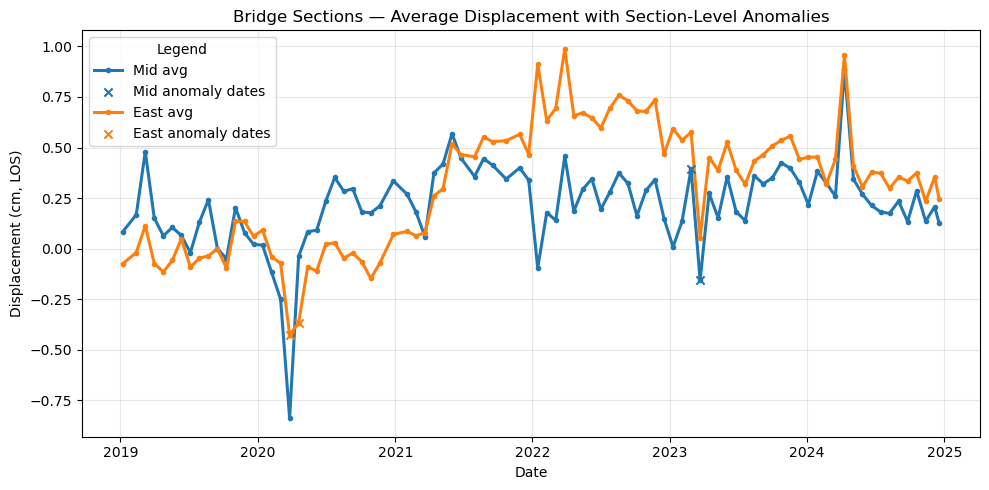

[Mid] 2 anomalous dates (max run=2). First: 20230227, Last: 20230323. Max |residual|=0.72 cm, Max |z|=11.80.
[East] 2 anomalous dates (max run=2). First: 20200326, Last: 20200419. Max |residual|=0.55 cm, Max |z|=16.67.


In [23]:
# ---------- NEW: section-level anomaly config ----------
SEC_ROLL_MED_WIN = 5   # window (in acquisitions) for rolling median baseline (use odd numbers like 5, 7)
SEC_CM_THRESH    = 0.2 # cm threshold on residual from baseline
SEC_Z_THRESH     = 3.0 # robust z-score threshold on residual
SEC_MIN_CONSEC   = 2   # require at least this many consecutive anomalous dates
# -------------------------------------------------------

def _max_run_length(bool_arr):
    """Max consecutive True run length in a 1D boolean array."""
    m = 0
    cur = 0
    for b in bool_arr:
        cur = cur + 1 if b else 0
        if cur > m:
            m = cur
    return m

def _enforce_min_consecutive(mask, k):
    """Keep only runs of True with length >= k."""
    if k <= 1:
        return mask.copy()
    out = np.zeros_like(mask, dtype=bool)
    n = mask.size
    i = 0
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]:
                j += 1
            if (j - i) >= k:
                out[i:j] = True
            i = j
        else:
            i += 1
    return out

def _rolling_median(x, win):
    """Rolling median with edge handling (uses nanmedian)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    half = win // 2
    rm = np.full(n, np.nan)
    for i in range(n):
        i0 = max(0, i - half)
        i1 = min(n, i + half + 1)
        rm[i] = np.nanmedian(x[i0:i1])
    return rm

# --- compute per-section averages (cm) + *section-level* anomaly detection ---
section_avg = {}             # name -> (n_dates,) cm
section_anom_mask = {}       # name -> (n_dates,) bool
section_resid = {}           # name -> residual cm (avg - rolling median)
section_flagged_idx = {}     # name -> indices of anomalous dates
section_summary_rows = []    # rows for per-section summary

for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])

    # collect each point's series (still needed to compute the average)
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # m -> cm

    arr = np.vstack(series_cm)                # (n_pts, n_dates)
    avg_cm = np.nanmean(arr, axis=0)         # (n_dates,)
    section_avg[sec_name] = avg_cm

    # --- NEW: section-level residual vs. rolling-median baseline ---
    base = _rolling_median(avg_cm, SEC_ROLL_MED_WIN)
    resid = avg_cm - base                     # (n_dates,)
    section_resid[sec_name] = resid

    # robust z-score of residual
    med_r = np.nanmedian(resid)
    mad_r = np.nanmedian(np.abs(resid - med_r))
    robust_std = 1.4826 * mad_r + 1e-9
    z = (resid - med_r) / robust_std

    # raw anomaly mask
    raw_mask = (np.abs(resid) > SEC_CM_THRESH) & (np.abs(z) > SEC_Z_THRESH)
    # enforce persistence
    mask = _enforce_min_consecutive(raw_mask, SEC_MIN_CONSEC)

    section_anom_mask[sec_name] = mask
    section_flagged_idx[sec_name] = np.where(mask)[0]

    # summary metrics
    n_flag = int(np.nansum(mask))
    max_run = _max_run_length(mask)
    first_date = dates[np.where(mask)[0][0]] if n_flag > 0 else ""
    last_date  = dates[np.where(mask)[0][-1]] if n_flag > 0 else ""
    max_abs_resid = float(np.nanmax(np.abs(resid))) if np.isfinite(resid).any() else 0.0
    max_abs_z     = float(np.nanmax(np.abs(z))) if np.isfinite(z).any() else 0.0

    section_summary_rows.append([
        sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z,
        SEC_ROLL_MED_WIN, SEC_CM_THRESH, SEC_Z_THRESH, SEC_MIN_CONSEC
    ])

# --- plot: section averages + overlay of *section-level* anomalous dates ---
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_sectionAvgs.png"
csv_name = f"{outbase}_ts_sectionAvgs.csv"
sec_anom_date_csv = f"{outbase}_section_anom_dates.csv"
sec_anom_summary_csv = f"{outbase}_section_anom_summary.csv"

plt.figure(figsize=(10, 5))
for sec_name, avg_series_cm in section_avg.items():
    # average curve
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=f"{sec_name} avg")
    # overlay anomalous dates for this section
    idx = section_flagged_idx[sec_name]
    if idx.size > 0:
        plt.scatter(dates_dt[idx], avg_series_cm[idx], s=35, marker="x", zorder=4, label=f"{sec_name} anomaly dates")

plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement with Section-Level Anomalies")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()
# plt.savefig(fig_name, dpi=200); plt.close()

# keep: CSV with one column per section average
with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + list(section_avg.keys()))
    for i, d in enumerate(dates):
        w.writerow([d] + [float(section_avg[name][i]) for name in section_avg.keys()])

# --- NEW: per-date section-level anomaly flags CSV (1/0 per section) ---
with open(sec_anom_date_csv, "w", newline="") as f:
    w = csv.writer(f)
    header = ["date"] + [f"{name}_flag" for name in section_avg.keys()]
    w.writerow(header)
    for i, d in enumerate(dates):
        w.writerow([d] + [int(section_anom_mask[name][i]) for name in section_avg.keys()])

# --- NEW: per-section summary CSV ---
with open(sec_anom_summary_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "section", "n_flagged_dates", "max_consecutive_flagged",
        "first_flagged_date", "last_flagged_date",
        "max_abs_residual_cm", "max_abs_robust_z",
        "cfg_roll_win", "cfg_cm_thresh", "cfg_z_thresh", "cfg_min_consec"
    ])
    w.writerows(section_summary_rows)

# console summary
for row in section_summary_rows:
    sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z, *_ = row
    if n_flag == 0:
        print(f"[{sec_name}] No section-level anomalies.")
    else:
        print(f"[{sec_name}] {n_flag} anomalous dates (max run={max_run}). "
              f"First: {first_date}, Last: {last_date}. "
              f"Max |residual|={max_abs_resid:.2f} cm, Max |z|={max_abs_z:.2f}.")


In [ ]:
sections = {
    "East_S1": {
        "points_str": "-47.46159935406088,-6.56050416644849;-47.46146373429202,-6.560468920830724;-47.46133077128363,-6.560438563882936;-47.46134626674425,-6.560370289325007;-47.46147585536021,-6.560402328449132;-47.46161531958357,-6.560432945876576;-47.46159935406088,-6.56050416644849 ",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S2": {
        "points_str": "-47.46130348920288,-6.560428485442362;-47.46116313409231,-6.560395837229959;-47.46099575417598,-6.56035720925049 ;-47.46101049572228,-6.560297594929002;-47.46117177651878,-6.560333628088344;-47.46131497525779,-6.560366494372492;-47.46130348920288,-6.560428485442362",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S3": {
        "points_str": "-47.46095796677579,-6.560348832338948;-47.46079646069482,-6.560309069960558;-47.46063750571581,-6.560273739331335;-47.46065103675672,-6.560214045251122;-47.46080687806177,-6.560249257433264;-47.46096836239918,-6.560286122425554;-47.46095796677579,-6.560348832338948",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S1": {
        "points_str": "-47.46060900757468,-6.560198250054605;-47.46059449768229,-6.560259839899425;-47.46043302983708,-6.560225335878401;-47.4602880936233,-6.560191829861957;-47.46029825726428,-6.560126693728696;-47.46045778823055,-6.560162137090549;-47.46060900757468,-6.560198250054605",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S2": {
        "points_str": "-47.46024701362929,-6.560183296170492;-47.46008648854441,-6.560148039799448;-47.45987171852053,-6.560095321136375;-47.45987808228551,-6.560033875740226;-47.4600987944757,-6.560085359451784;-47.46026005484211,-6.560121155016233;-47.46024701362929,-6.560183296170492",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S3": {
        "points_str": "-47.45984185771984,-6.560087645971586;-47.4596453876067,-6.560044880155928;-47.45944605995008,-6.559999092449311;-47.45946274437678,-6.559938014459747;-47.45965617287498,-6.55998361919587;-47.45985112158873,-6.560027804382649;-47.45984185771984,-6.560087645971586",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S1": {
        "points_str": "-47.45940799922867,-6.559919641117872;-47.45939199985407,-6.559981281395009;-47.45919391730619,-6.559942865288215;-47.45899807741331,-6.55989957229934;-47.45901043519845,-6.559835377698351;-47.45921368939044,-6.559877483777482;-47.45940799922867,-6.559919641117872",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S2": {
        "points_str": "-47.45896661527618,-6.559894742286868;-47.45881581930044,-6.559862098020168;-47.45861712759962,-6.559816215657076;-47.45863066775841,-6.559756601631374;-47.45882659329846,-6.559799414525194;-47.45898044201245,-6.559830642898655;-47.45896661527618,-6.559894742286868",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S3": {
        "points_str": "-47.45858651753384,-6.559806466086134;-47.45844677452839,-6.559778545068137;-47.45830264709105,-6.559746196402275;-47.45831742489085,-6.559683801501984;-47.45846016447318,-6.55971607723477;-47.45860150386818,-6.559748360350736;-47.45858651753384,-6.559806466086134",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    
}



# -47.46159935406088,-6.56050416644849;-47.46146373429202,-6.560468920830724;-47.46133077128363,-6.560438563882936;-47.46134626674425,-6.560370289325007;-47.46147585536021,-6.560402328449132;-47.46161531958357,-6.560432945876576;-47.46159935406088,-6.56050416644849 
# -47.46130348920288,-6.560428485442362;-47.46116313409231,-6.560395837229959;-47.46099575417598,-6.56035720925049 ;-47.46101049572228,-6.560297594929002;-47.46117177651878,-6.560333628088344;-47.46131497525779,-6.560366494372492;-47.46130348920288,-6.560428485442362 
# -47.46095796677579,-6.560348832338948;-47.46079646069482,-6.560309069960558;-47.46063750571581,-6.560273739331335;-47.46065103675672,-6.560214045251122;-47.46080687806177,-6.560249257433264;-47.46096836239918,-6.560286122425554;-47.46095796677579,-6.560348832338948 
# -47.46060900757468,-6.560198250054605;-47.46059449768229,-6.560259839899425;-47.46043302983708,-6.560225335878401;-47.4602880936233,-6.560191829861957;-47.46029825726428,-6.560126693728696;-47.46045778823055,-6.560162137090549;-47.46060900757468,-6.560198250054605 
# -47.46024701362929,-6.560183296170492;-47.46008648854441,-6.560148039799448;-47.45987171852053,-6.560095321136375;-47.45987808228551,-6.560033875740226;-47.4600987944757,-6.560085359451784;-47.46026005484211,-6.560121155016233;-47.46024701362929,-6.560183296170492 
# -47.45984185771984,-6.560087645971586;-47.4596453876067,-6.560044880155928;-47.45944605995008,-6.559999092449311;-47.45946274437678,-6.559938014459747;-47.45965617287498,-6.55998361919587;-47.45985112158873,-6.560027804382649;-47.45984185771984,-6.560087645971586 
# -47.45940799922867,-6.559919641117872;-47.45939199985407,-6.559981281395009;-47.45919391730619,-6.559942865288215;-47.45899807741331,-6.55989957229934;-47.45901043519845,-6.559835377698351;-47.45921368939044,-6.559877483777482;-47.45940799922867,-6.559919641117872 
# -47.45896661527618,-6.559894742286868;-47.45881581930044,-6.559862098020168;-47.45861712759962,-6.559816215657076;-47.45863066775841,-6.559756601631374;-47.45882659329846,-6.559799414525194;-47.45898044201245,-6.559830642898655;-47.45896661527618,-6.559894742286868 
# -47.45858651753384,-6.559806466086134;-47.45844677452839,-6.559778545068137;-47.45830264709105,-6.559746196402275;-47.45831742489085,-6.559683801501984;-47.45846016447318,-6.55971607723477;-47.45860150386818,-6.559748360350736;-47.45858651753384,-6.559806466086134 




timeseries shape: (89, 422, 315)


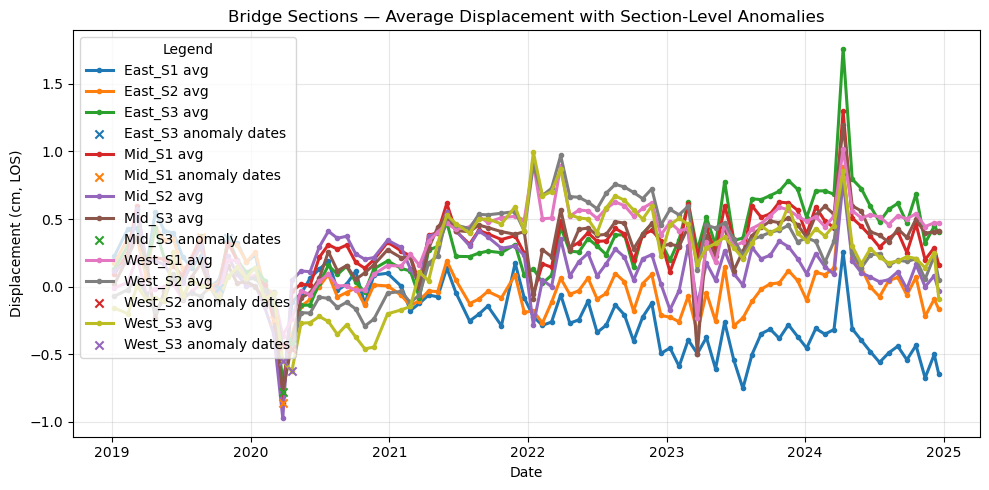

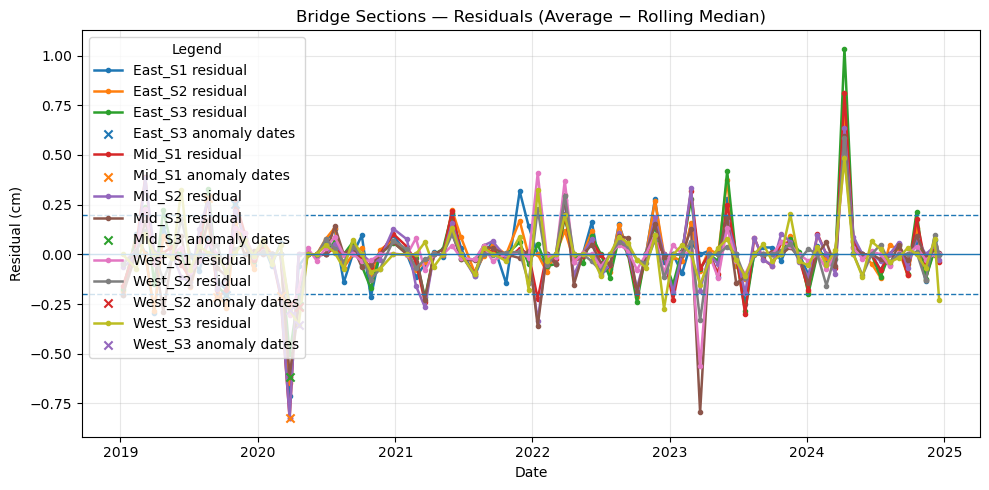

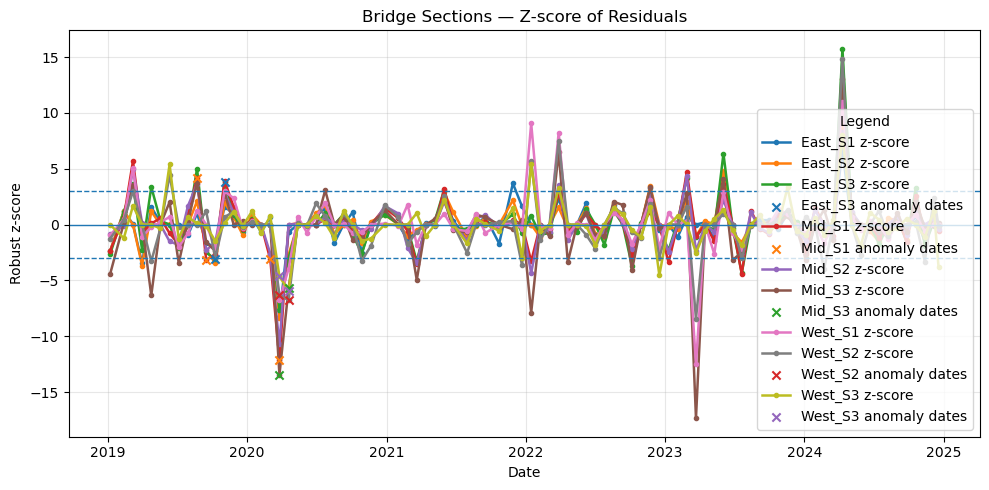

[East_S1] No section-level anomalies.
[East_S2] No section-level anomalies.
[East_S3] 2 anomalous dates (max run=2). First: 20191010, Last: 20191103. Max |residual|=1.03 cm, Max |z|=15.73.
[Mid_S1] 4 anomalous dates (max run=2). First: 20190823, Last: 20200326. Max |residual|=0.82 cm, Max |z|=12.10.
[Mid_S2] No section-level anomalies.
[Mid_S3] 2 anomalous dates (max run=2). First: 20200326, Last: 20200419. Max |residual|=0.79 cm, Max |z|=17.33.
[West_S1] No section-level anomalies.
[West_S2] 2 anomalous dates (max run=2). First: 20200326, Last: 20200419. Max |residual|=0.58 cm, Max |z|=14.83.
[West_S3] 2 anomalous dates (max run=2). First: 20200326, Last: 20200419. Max |residual|=0.48 cm, Max |z|=8.02.


In [26]:
import os
os.chdir("/insar-data/Tocantins/mintpy")

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mintpy.utils import readfile
import h5py
import csv

# --- helpers ---
def parse_points(s):
    pts = []
    for item in s.split(";"):
        lon_str, lat_str = item.strip().split(",")
        pts.append((float(lat_str), float(lon_str)))
    return pts

def latlon_to_rc(meta, lat, lon):
    x0 = float(meta["X_FIRST"])
    y0 = float(meta["Y_FIRST"])
    dx = float(meta["X_STEP"])
    dy = float(meta["Y_STEP"])    # often negative
    width  = int(meta["WIDTH"])
    length = int(meta["LENGTH"])
    col = int(round((lon - x0) / dx))
    row = int(round((lat - y0) / dy))
    if not (0 <= row < length and 0 <= col < width):
        raise IndexError(f"Point ({lat:.6f},{lon:.6f}) -> (row={row}, col={col}) outside data [{length}x{width}]")
    return row, col

def _to_str_array(x):
    """Normalize various 'date list' representations to an array of 'YYYYMMDD' strings."""
    if isinstance(x, np.ndarray):
        if x.dtype.kind in ("S", "U", "O"):
            arr = [xi.decode() if isinstance(xi, (bytes, bytearray)) else str(xi) for xi in x.tolist()]
        else:  # e.g., int array like [20171005, ...]
            arr = [f"{int(xi):08d}" for xi in x.tolist()]
    elif isinstance(x, (bytes, bytearray, str)):
        s = x.decode() if isinstance(x, (bytes, bytearray)) else x
        arr = [t for t in s.replace(",", " ").split() if t]
    else:
        arr = [str(x)]
    return np.array(arr)

def get_dates(h5_file):
    """Robust date reader: try '/date' dataset; fall back to DATE_LIST or similar attrs (root or '/timeseries')."""
    try:
        dates_raw, _ = readfile.read(h5_file, datasetName="date")
        return np.array([d.decode() if isinstance(d, (bytes, bytearray)) else str(d) for d in dates_raw])
    except Exception:
        pass

    with h5py.File(h5_file, "r") as f:
        if "date" in f:
            return _to_str_array(f["date"][:])
        root_keys = ["DATE_LIST", "DATE", "DATES"]
        ts_keys   = ["DATE_LIST", "DATE", "DATES", "date"]
        for k in root_keys:
            if k in f.attrs:
                return _to_str_array(f.attrs[k])
        if "timeseries" in f:
            for k in ts_keys:
                if k in f["timeseries"].attrs:
                    return _to_str_array(f["timeseries"].attrs[k])
        try:
            _, meta = readfile.read(h5_file)
            for k in ["DATE_LIST", "DATE", "DATES"]:
                if k in meta:
                    return _to_str_array(meta[k])
        except Exception:
            pass

    raise RuntimeError("Could not find dates in the file (no '/date' dataset or date attributes like 'DATE_LIST').")

# ---------- inputs ----------
sections = {
    "East_S1": {
        "points_str": "-47.46159935406088,-6.56050416644849;-47.46146373429202,-6.560468920830724;-47.46133077128363,-6.560438563882936;-47.46134626674425,-6.560370289325007;-47.46147585536021,-6.560402328449132;-47.46161531958357,-6.560432945876576;-47.46159935406088,-6.56050416644849 ",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S2": {
        "points_str": "-47.46130348920288,-6.560428485442362;-47.46116313409231,-6.560395837229959;-47.46099575417598,-6.56035720925049 ;-47.46101049572228,-6.560297594929002;-47.46117177651878,-6.560333628088344;-47.46131497525779,-6.560366494372492;-47.46130348920288,-6.560428485442362",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S3": {
        "points_str": "-47.46095796677579,-6.560348832338948;-47.46079646069482,-6.560309069960558;-47.46063750571581,-6.560273739331335;-47.46065103675672,-6.560214045251122;-47.46080687806177,-6.560249257433264;-47.46096836239918,-6.560286122425554;-47.46095796677579,-6.560348832338948",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S1": {
        "points_str": "-47.46060900757468,-6.560198250054605;-47.46059449768229,-6.560259839899425;-47.46043302983708,-6.560225335878401;-47.4602880936233,-6.560191829861957;-47.46029825726428,-6.560126693728696;-47.46045778823055,-6.560162137090549;-47.46060900757468,-6.560198250054605",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S2": {
        "points_str": "-47.46024701362929,-6.560183296170492;-47.46008648854441,-6.560148039799448;-47.45987171852053,-6.560095321136375;-47.45987808228551,-6.560033875740226;-47.4600987944757,-6.560085359451784;-47.46026005484211,-6.560121155016233;-47.46024701362929,-6.560183296170492",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S3": {
        "points_str": "-47.45984185771984,-6.560087645971586;-47.4596453876067,-6.560044880155928;-47.45944605995008,-6.559999092449311;-47.45946274437678,-6.559938014459747;-47.45965617287498,-6.55998361919587;-47.45985112158873,-6.560027804382649;-47.45984185771984,-6.560087645971586",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S1": {
        "points_str": "-47.45940799922867,-6.559919641117872;-47.45939199985407,-6.559981281395009;-47.45919391730619,-6.559942865288215;-47.45899807741331,-6.55989957229934;-47.45901043519845,-6.559835377698351;-47.45921368939044,-6.559877483777482;-47.45940799922867,-6.559919641117872",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S2": {
        "points_str": "-47.45896661527618,-6.559894742286868;-47.45881581930044,-6.559862098020168;-47.45861712759962,-6.559816215657076;-47.45863066775841,-6.559756601631374;-47.45882659329846,-6.559799414525194;-47.45898044201245,-6.559830642898655;-47.45896661527618,-6.559894742286868",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S3": {
        "points_str": "-47.45858651753384,-6.559806466086134;-47.45844677452839,-6.559778545068137;-47.45830264709105,-6.559746196402275;-47.45831742489085,-6.559683801501984;-47.45846016447318,-6.55971607723477;-47.45860150386818,-6.559748360350736;-47.45858651753384,-6.559806466086134",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    
}

h5_file = "/insar-data/Tocantins/mintpy/geo/geo_timeseries_ERA5_demErr.h5"

# ---------- section-level anomaly config ----------
SEC_ROLL_MED_WIN = 5   # window (in acquisitions) for rolling median baseline (odd numbers: 5, 7, 9...)
SEC_CM_THRESH    = 0.2 # cm threshold on residual from baseline
SEC_Z_THRESH     = 3.0 # robust z-score threshold on residual
SEC_MIN_CONSEC   = 2   # require at least this many consecutive anomalous dates

# ---------- small utilities ----------
def _max_run_length(bool_arr):
    """Max consecutive True run length in a 1D boolean array."""
    m = 0
    cur = 0
    for b in bool_arr:
        cur = cur + 1 if b else 0
        if cur > m:
            m = cur
    return m

def _enforce_min_consecutive(mask, k):
    """Keep only runs of True with length >= k."""
    if k <= 1:
        return mask.copy()
    out = np.zeros_like(mask, dtype=bool)
    n = mask.size
    i = 0
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]:
                j += 1
            if (j - i) >= k:
                out[i:j] = True
            i = j
        else:
            i += 1
    return out

def _rolling_median(x, win):
    """Rolling median with edge handling (centered window; uses nanmedian)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    half = win // 2
    rm = np.full(n, np.nan)
    for i in range(n):
        i0 = max(0, i - half)
        i1 = min(n, i + half + 1)
        rm[i] = np.nanmedian(x[i0:i1])
    return rm

# ---------- read data ----------
ts, meta = readfile.read(h5_file)  # 3-D (n_date, length, width), meters
print("timeseries shape:", ts.shape)

dates = get_dates(h5_file)
dates_dt = np.array([datetime.strptime(d, "%Y%m%d") for d in dates])

# ---------- compute per-section averages + section-level anomalies ----------
section_avg = {}             # name -> (n_dates,) cm
section_anom_mask = {}       # name -> (n_dates,) bool
section_resid = {}           # name -> residual cm (avg - rolling median)
section_flagged_idx = {}     # name -> indices of anomalous dates
section_z = {}               # name -> robust z-score array (n_dates,)
section_summary_rows = []    # rows for per-section summary

for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])

    # collect each point's time-series (cm)
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # m -> cm

    arr = np.vstack(series_cm)                # (n_pts, n_dates)
    avg_cm = np.nanmean(arr, axis=0)         # (n_dates,)
    section_avg[sec_name] = avg_cm

    # residual vs. rolling-median baseline
    base = _rolling_median(avg_cm, SEC_ROLL_MED_WIN)
    resid = avg_cm - base
    section_resid[sec_name] = resid

    # robust z-score of residual
    med_r = np.nanmedian(resid)
    mad_r = np.nanmedian(np.abs(resid - med_r))
    robust_std = 1.4826 * mad_r + 1e-9
    z = (resid - med_r) / robust_std
    section_z[sec_name] = z

    # anomaly mask and persistence constraint
    raw_mask = (np.abs(resid) > SEC_CM_THRESH) & (np.abs(z) > SEC_Z_THRESH)
    mask = _enforce_min_consecutive(raw_mask, SEC_MIN_CONSEC)
    section_anom_mask[sec_name] = mask
    section_flagged_idx[sec_name] = np.where(mask)[0]

    # summary
    n_flag = int(np.nansum(mask))
    max_run = _max_run_length(mask)
    first_date = dates[np.where(mask)[0][0]] if n_flag > 0 else ""
    last_date  = dates[np.where(mask)[0][-1]] if n_flag > 0 else ""
    max_abs_resid = float(np.nanmax(np.abs(resid))) if np.isfinite(resid).any() else 0.0
    max_abs_z     = float(np.nanmax(np.abs(z))) if np.isfinite(z).any() else 0.0

    section_summary_rows.append([
        sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z,
        SEC_ROLL_MED_WIN, SEC_CM_THRESH, SEC_Z_THRESH, SEC_MIN_CONSEC
    ])

# ---------- plotting ----------
outbase = os.path.splitext(os.path.basename(h5_file))[0]
fig_name = f"{outbase}_ts_sectionAvgs.png"
csv_name = f"{outbase}_ts_sectionAvgs.csv"
sec_anom_date_csv = f"{outbase}_section_anom_dates.csv"
sec_anom_summary_csv = f"{outbase}_section_anom_summary.csv"
resid_fig_name = f"{outbase}_ts_sectionResiduals.png"
z_fig_name = f"{outbase}_ts_sectionZscores.png"

# 1) section averages with anomaly markers
plt.figure(figsize=(10, 5))
for sec_name, avg_series_cm in section_avg.items():
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=f"{sec_name} avg")
    idx = section_flagged_idx[sec_name]
    if idx.size > 0:
        plt.scatter(dates_dt[idx], avg_series_cm[idx], s=35, marker="x", zorder=4, label=f"{sec_name} anomaly dates")
plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement with Section-Level Anomalies")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()
# plt.savefig(fig_name, dpi=200); plt.close()

# 2) residual plot
plt.figure(figsize=(10, 5))
for sec_name, resid in section_resid.items():
    plt.plot(dates_dt, resid, linewidth=1.8, marker="o", markersize=3, label=f"{sec_name} residual")
    idx = section_flagged_idx[sec_name]
    if idx.size > 0:
        plt.scatter(dates_dt[idx], resid[idx], s=35, marker="x", zorder=4, label=f"{sec_name} anomaly dates")
plt.axhline(0.0, linewidth=1.0)
plt.axhline(+SEC_CM_THRESH, linewidth=1.0, linestyle="--")
plt.axhline(-SEC_CM_THRESH, linewidth=1.0, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Residual (cm)")
plt.title("Bridge Sections — Residuals (Average − Rolling Median)")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()
# plt.savefig(resid_fig_name, dpi=200); plt.close()

# 3) z-score plot
plt.figure(figsize=(10, 5))
for sec_name, z in section_z.items():
    plt.plot(dates_dt, z, linewidth=1.8, marker="o", markersize=3, label=f"{sec_name} z-score")
    idx = section_flagged_idx[sec_name]
    if idx.size > 0:
        plt.scatter(dates_dt[idx], z[idx], s=35, marker="x", zorder=4, label=f"{sec_name} anomaly dates")
plt.axhline(0.0, linewidth=1.0)
plt.axhline(+SEC_Z_THRESH, linewidth=1.0, linestyle="--")
plt.axhline(-SEC_Z_THRESH, linewidth=1.0, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Robust z-score")
plt.title("Bridge Sections — Z-score of Residuals")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()
# plt.savefig(z_fig_name, dpi=200); plt.close()

# ---------- CSV exports ----------
# per-date section averages
with open(csv_name, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["date"] + list(section_avg.keys()))
    for i, d in enumerate(dates):
        w.writerow([d] + [float(section_avg[name][i]) for name in section_avg.keys()])

# per-date section-level anomaly flags (1/0)
with open(sec_anom_date_csv, "w", newline="") as f:
    w = csv.writer(f)
    header = ["date"] + [f"{name}_flag" for name in section_avg.keys()]
    w.writerow(header)
    for i, d in enumerate(dates):
        w.writerow([d] + [int(section_anom_mask[name][i]) for name in section_avg.keys()])

# per-section summary
with open(sec_anom_summary_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "section", "n_flagged_dates", "max_consecutive_flagged",
        "first_flagged_date", "last_flagged_date",
        "max_abs_residual_cm", "max_abs_robust_z",
        "cfg_roll_win", "cfg_cm_thresh", "cfg_z_thresh", "cfg_min_consec"
    ])
    w.writerows(section_summary_rows)

# console summary
for row in section_summary_rows:
    sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z, *_ = row
    if n_flag == 0:
        print(f"[{sec_name}] No section-level anomalies.")
    else:
        print(f"[{sec_name}] {n_flag} anomalous dates (max run={max_run}). "
              f"First: {first_date}, Last: {last_date}. "
              f"Max |residual|={max_abs_resid:.2f} cm, Max |z|={max_abs_z:.2f}.")


In [3]:


import h5py
import matplotlib.pyplot as plt
import numpy as np

fname = "/insar-data/Miaplpy_Tocantins/miaplpy/network_single_reference/geo/geo_velocity.h5"

import h5py

with h5py.File(fname, "r") as f:
    print("Datasets:", list(f.keys()))
    print("Attributes:", list(f.attrs.keys()))

Datasets: ['intercept', 'interceptStd', 'residue', 'velocity', 'velocityStd']
Attributes: ['ALOOKS', 'ANTENNA_SIDE', 'AZIMUTH_PIXEL_SIZE', 'BANDS', 'CENTER_INCIDENCE_ANGLE', 'CENTER_LINE_UTC', 'DATA_TYPE', 'DATE12', 'EARTH_RADIUS', 'END_DATE', 'FILE_LENGTH', 'FILE_PATH', 'FILE_TYPE', 'HEADING', 'HEIGHT', 'INTERLEAVE', 'LAT_REF1', 'LAT_REF2', 'LAT_REF3', 'LAT_REF4', 'LENGTH', 'LON_REF1', 'LON_REF2', 'LON_REF3', 'LON_REF4', 'NCORRLOOKS', 'NO_DATA_VALUE', 'OG_FILE_PATH', 'ORBIT_DIRECTION', 'PLATFORM', 'POLARIZATION', 'PRF', 'PROCESSOR', 'PROJECT_NAME', 'P_BASELINE_BOTTOM_HDR', 'P_BASELINE_TOP_HDR', 'RANGE_PIXEL_SIZE', 'REF_DATE', 'REF_LAT', 'REF_LON', 'REF_X', 'REF_Y', 'RLOOKS', 'STARTING_RANGE', 'START_DATE', 'UNIT', 'WAVELENGTH', 'WIDTH', 'X_FIRST', 'X_STEP', 'X_UNIT', 'Y_FIRST', 'Y_STEP', 'Y_UNIT', 'access_mode', 'altitude', 'azimuthPixelSize', 'azimuthResolution', 'beam_mode', 'beam_swath', 'byte_order', 'data_type', 'earthRadius', 'extra_file_name', 'family', 'file_name', 'interpolat

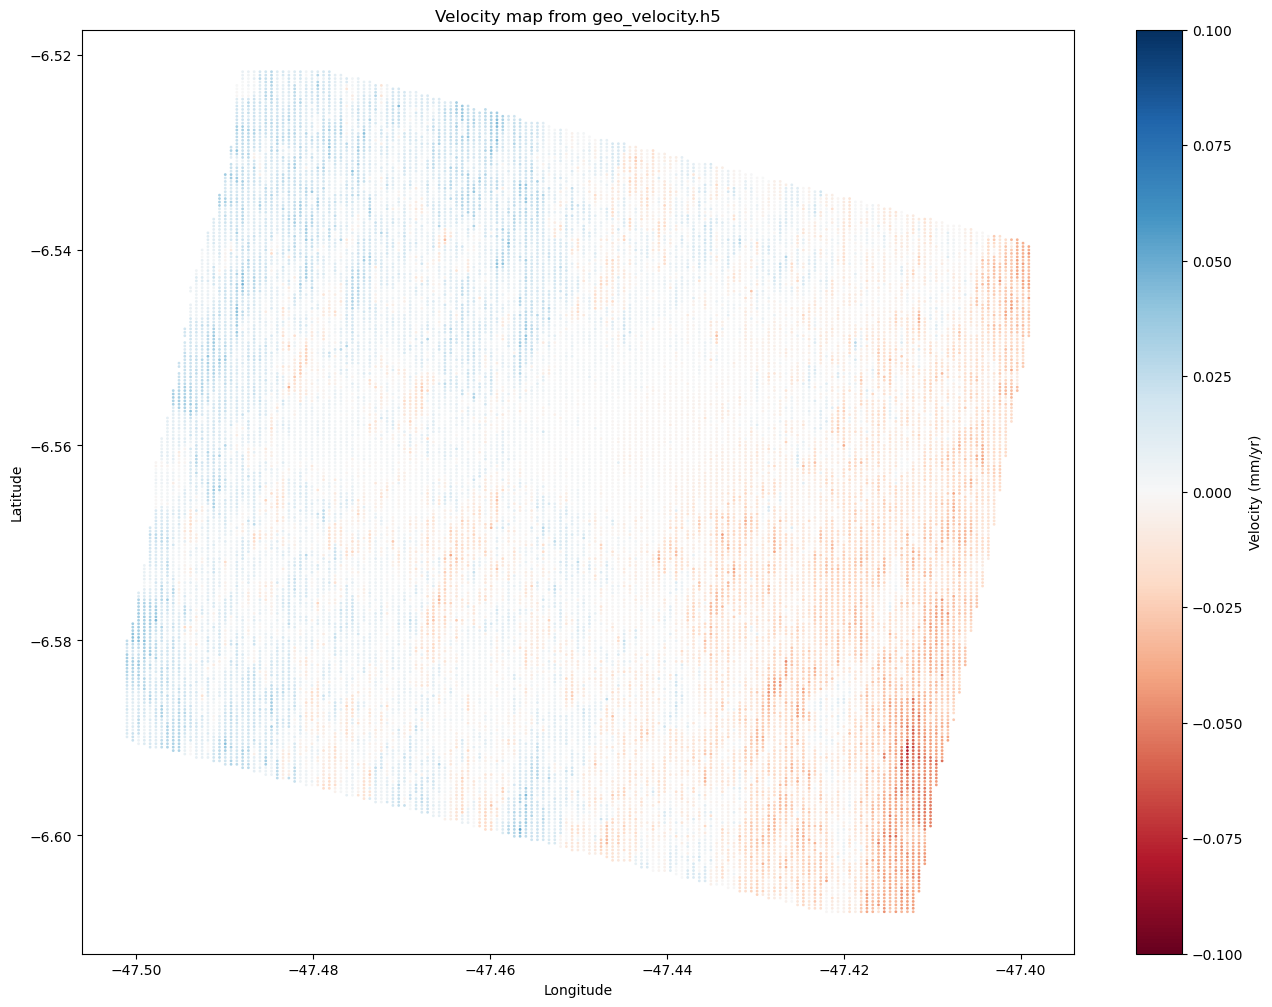

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

fname = "/insar-data/Miaplpy_Tocantins/miaplpy/network_single_reference/geo/geo_velocity.h5"

with h5py.File(fname, "r") as f:
    vel = f["velocity"][:]

    # safely convert attributes to float/int
    x_first = float(f.attrs["X_FIRST"])
    x_step  = float(f.attrs["X_STEP"])
    width   = int(f.attrs["WIDTH"])

    y_first = float(f.attrs["Y_FIRST"])
    y_step  = float(f.attrs["Y_STEP"])
    length  = int(f.attrs["LENGTH"])

# coordinate vectors
lon_vec = x_first + np.arange(width) * x_step
lat_vec = y_first + np.arange(length) * y_step

# full 2D grids
lon, lat = np.meshgrid(lon_vec, lat_vec)

# plot scatter
plt.figure(figsize=(16,12))
sc = plt.scatter(lon.flatten(), lat.flatten(), c=vel.flatten(),
                 s=1, cmap="RdBu", vmin=-0.1, vmax=0.1)
plt.colorbar(sc, label="Velocity (mm/yr)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Velocity map from geo_velocity.h5")
plt.show()
